__File: snmd_lamb_dependence.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jun 18, 2021__

Testing $\lambda$ dependence of proton momentum distribution.

In [1]:
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
# Scripts made by A.T.
from figures import figures_functions as ff
from figures import register_colormap
from densities import load_density
from potentials.vsrg_macos import vnn
from snmd import single_nucleon_momentum_distributions
from srg.srg_unitary_transformation import SRG_unitary_transformation

__Set-up__

In [2]:
def setup_rc_params(presentation=False):
    """
    Set matplotlib's rc parameters for the plots
    
    Parameters
    ----------
    presentation : bool, optional
        Option to enlarge font sizes for presentations.
    
    """

    if presentation:
        fontsize = 14
    else:
        fontsize = 9
    black = 'k'

    mpl.rcdefaults()  # Set to defaults

#     mpl.rc('text', usetex=True)
    mpl.rcParams['font.size'] = fontsize
#     mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'

#     mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.edgecolor'] = black
    # mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.labelcolor'] = black
#     mpl.rcParams['axes.titlesize'] = fontsize

    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['xtick.color'] = black
    mpl.rcParams['ytick.color'] = black
    # Make the ticks thin enough to not be visible at the limits of the plot (over the axes border)
    mpl.rcParams['xtick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    mpl.rcParams['ytick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    # The minor ticks are little too small, make them both bigger.
    mpl.rcParams['xtick.minor.size'] = 2.4  # Default 2.0
    mpl.rcParams['ytick.minor.size'] = 2.4
    mpl.rcParams['xtick.major.size'] = 3.9  # Default 3.5
    mpl.rcParams['ytick.major.size'] = 3.9
    
    # Added by A.T.
    # Puts tick marks (not labels) on top and right axes
    mpl.rcParams['xtick.top'] = True
    mpl.rcParams['ytick.right'] = True
    
    ppi = 72  # points per inch
    # dpi = 150
#     mpl.rcParams['figure.titlesize'] = fontsize
    mpl.rcParams['figure.dpi'] = 150  # To show up reasonably in notebooks
    mpl.rcParams['figure.constrained_layout.use'] = False
    # 0.02 and 3 points are the defaults:
    # can be changed on a plot-by-plot basis using fig.set_constrained_layout_pads()
    mpl.rcParams['figure.constrained_layout.wspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.hspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.h_pad'] = 3. / ppi  # 3 points
    mpl.rcParams['figure.constrained_layout.w_pad'] = 3. / ppi

#     mpl.rcParams['legend.title_fontsize'] = fontsize
#     mpl.rcParams['legend.fontsize'] = fontsize
    mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
    # Set facecolor with its own alpha, so edgecolor is unaffected
    mpl.rcParams['legend.fancybox'] = True
    mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)
#     mpl.rcParams['legend.borderaxespad'] = 0.8
    # Do not set overall alpha (affects edgecolor). Handled by facecolor above
    mpl.rcParams['legend.framealpha'] = None
    # This is for legend edgewidth, since it does not have its own option
    mpl.rcParams['patch.linewidth'] = 0.8
    mpl.rcParams['hatch.linewidth'] = 0.5

    # bbox = 'tight' can distort the figure size when saved (that's its purpose).
    # mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.04, dpi=350, format='png')
    # mpl.rc('savefig', transparent=False, bbox=None, dpi=400, format='png')
    mpl.rc('savefig', bbox='tight', dpi=400)

In [3]:
# Run this cell to customize matplotlib graphics (see setup_rc_params for details)
setup_rc_params(presentation=True)

In [4]:
# Save figures in the following directory (you can change this in the Dropbox)
figure_directory = 'figures/src_physics'

kvnn = 6
channels = ('1S0', '3S1')
# try this
# channels = ('1S0', '3S1', '3P0', '1P1', '3P1')
lambda_array = np.append( np.arange(8.0, 1.0, -0.5), 1.35 )
m = len(lambda_array)
kmax, kmid, ntot = 15.0, 3.0, 120

# q values
q_points = np.array([1.5, 2.0, 3.0, 4.0, 5.0])
n = len(q_points)

# Momenta and weights
q_array, q_weights = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)

# Nucleus
# nucleus = ('C12', 6, 6)
nucleus = ('Pb208', 82, 126)

nucleus_name = nucleus[0]
Z = nucleus[1]
N = nucleus[2]

# Load densities
R_array, rho_p_array = load_density(nucleus_name, 'proton', Z, N)
R_array, rho_n_array = load_density(nucleus_name, 'neutron', Z, N)
dR = R_array[2] - R_array[1]

__SRG-evolve AV18__

In [5]:
# Already did 8, 7.5, ..., 1.5, 1.35
# Add more?

# from run_srg import run_srg

# for channel in channels:
#     d = run_srg(kvnn, channel, kmax, kmid, ntot, 'Wegner', lambda_array, save=True)

__Calculate proton $n_{\lambda}^A(q_i)$ for fixed $q_i$__

In [6]:
# Calculate n_{\lambda_i}^A(q_j) for ith \lambda and jth q

# Initialize array for data
proton_snmd_array = np.zeros( (m, n) )

# Do full momentum array?
full = True
# full = False
if full:
    n_p_array = np.zeros( (m, ntot) )

# Loop over \lambda values
for i, lamb in enumerate(lambda_array):

    # Initialize class
    snmd = single_nucleon_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot, interp=False)
    
    # Try using interpolated version first
    try:
        n_p_func, _, _, _ = snmd.n_lambda_interp(nucleus_name, 'proton', Z, N)
    # Need to generate the files first
    except OSError:
        if Z < 6:
            edf = 'AV18'
        else:
            edf = 'SLY4'
        snmd.write_file(nucleus_name, 'proton', Z, N, edf)
        n_p_func, _, _, _ = snmd.n_lambda_interp(nucleus_name, 'proton', Z, N)
    
    # Fill in array for particular \lambda
    proton_snmd_array[i, :] = n_p_func(q_points)

#     # Evaluate momentum distribution at q_i
#     # proton_snmd_array[i, :] = snmd.n_lambda(q_points, R_array, rho_p_array, rho_n_array)[:, 0]
#     proton_snmd_array[i, :] = snmd.n_total(q_points, R_array, dR, rho_p_array, rho_n_array)
    
    if full:
#         n_p_array[i, :] = snmd.n_total(q_array, R_array, dR, rho_p_array, rho_n_array)
        n_p_array[i, :] = n_p_func(q_array)

__Plot proton $n_{\lambda}^A(q_i)$ for fixed $q_i$ with respect to $\lambda$__

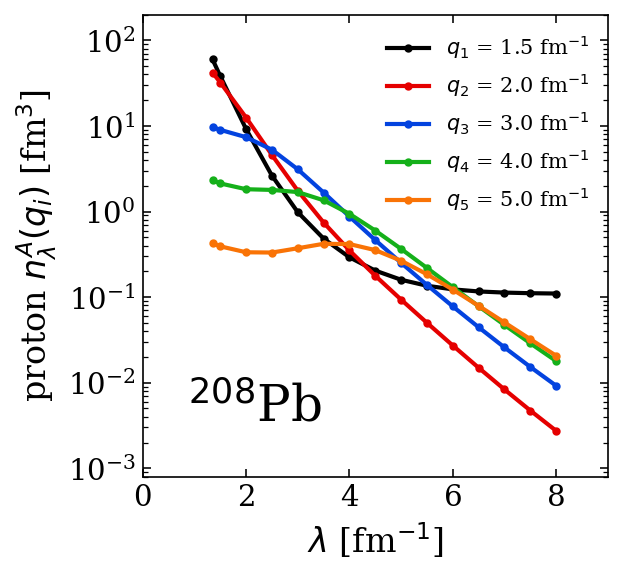

In [7]:
# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = r'$\lambda$' + ' [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = 'proton ' + r'$n_{\lambda}^A(q_i)$' + ' [fm' + r'$^3$' + ']'
y_label_size = 16

# Axes limits
xlim = (0.0, 9.0)
if nucleus_name == 'C12':
    ylim = (3e-5, 1e1)
elif nucleus_name == 'Pb208':
    ylim = (8e-4, 2e2)
    
# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)

# Set y-axis to log scale
ax.set_yscale('log')

# Loop over q_i points
for i, q_i in enumerate(q_points):
    
    # Legend label
    curve_label = r'$q_{%d}$' % (i+1) + ' = %s fm' % ff.convert_number_to_string(q_i) + r'$^{-1}$'
    curve_color = ff.xkcd_colors(i)
    
    # Add curve to figure
    ax.plot(lambda_array, proton_snmd_array[:, i], color=curve_color, marker='.', label=curve_label,
            linewidth=curve_width)

# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
        
# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Add legend
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
ax.legend(loc='upper right', fontsize=10, frameon=False)

# Add nucleus label as anchored text
nuc_label = ff.nuclei_label_conversion(nucleus_name)
nuc_label_location = 'lower left'
nuc_label_size = 24
anchored_text = AnchoredText(nuc_label, loc=nuc_label_location, prop=dict(size=nuc_label_size), frameon=False)
ax.add_artist(anchored_text)

# Set file_name 
file_name = 'snmd_lamb_dep_kvnn_%d_%s.png' % (kvnn, nucleus_name)

# Save figure
f.savefig(figure_directory + '/' + file_name)

__Plot proton $n_{\lambda_i}^A(q)$ for fixed $\lambda_i$ with respect to $q$__

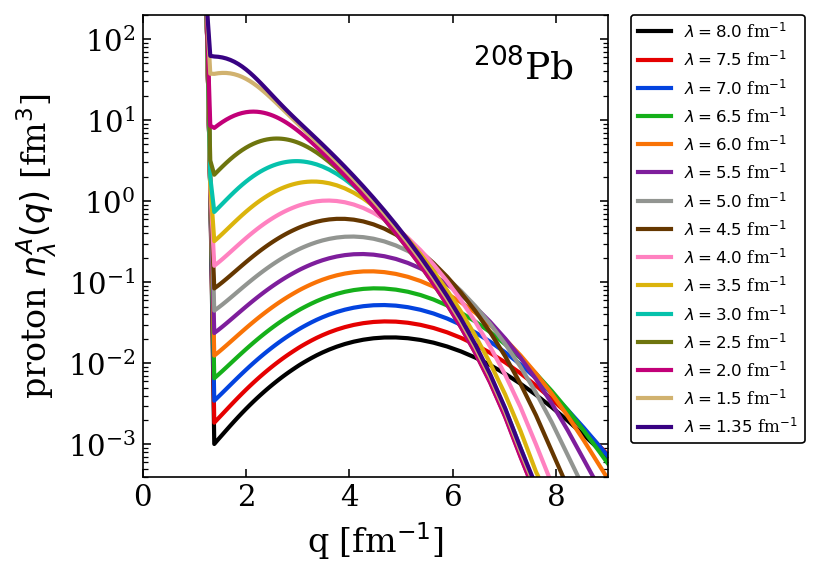

In [8]:
# Plot single-nucleon momentum distributions comparing to AV18 data varying \lambda values
# Copied from src_physics_fig.ipynb

# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'q [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = 'proton ' + r'$n_{\lambda}^A(q)$' + ' [fm' + r'$^3$' + ']'
y_label_size = 16

xlim = (0.0, 9.0)
if nucleus_name == 'C12':
    ylim = (3e-5, 1e1)
elif nucleus_name == 'Pb208':
    ylim = (4e-4, 2e2)
    
# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)
    
# Set y-axis to log scale
ax.set_yscale('log')

# Plot each for each \lambda value in lambda_array
for i, lamb in enumerate(lambda_array):

    # Legend label
    curve_label = ff.lambda_label_conversion(lamb) # Labels \lambda
    
    # Select curve color for each \lambda (15 \lambda values)
    curve_color = ff.xkcd_colors(i)
     
    # Add curve to figure
    ax.plot(q_array, n_p_array[i, :], label=curve_label, linewidth=curve_width, color=curve_color)

# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)
        
# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Add legend
legend_size = 8
legend_location = 'upper left'
ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)
           
# Add nucleus label
nucleus_label = ff.nuclei_label_conversion(nucleus_name)
nucleus_label_location = 'upper right'
nucleus_label_size = 18
anchored_text = AnchoredText(nuc_label, loc=nucleus_label_location, prop=dict(size=nucleus_label_size),
                             frameon=False)
ax.add_artist(anchored_text)
           
# Set file name
file_name = 'snmd_with_AV18_vary_lambda_%s' % nucleus_name
# Add each channel to file name
file_name += '_channels'
for ichannel in channels:
    file_name += '_%s' % ichannel
file_name += '_kvnn_%d_lambdas' % 6
# Add each \lambda to file name
for ilamb in lambda_array:
    file_name += '_%s' % ff.convert_number_to_string(ilamb)
file_name += '_kmax_%.1f' % kmax
# Replace periods
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

__$\delta U$ contour plots__

In [9]:
# Get matrix elements of \delta U in 3S1-3D1 channel

# For dividing out momenta/weights
factor_array = np.sqrt( (2*q_weights) / np.pi ) * q_array
# For coupled-channel matrices
factor_array_cc = np.concatenate( (factor_array, factor_array) )

# Store in dictionary for a few \lambda values
d = {}
lambdas = [8.0, 6.0, 3.0, 2.0, 1.35]
for lamb in lambdas:

    # Load SRG transformation
    H_initial = vnn.load_hamiltonian(kvnn, '3S1', kmax, kmid, ntot)
    H_evolved = vnn.load_hamiltonian(kvnn, '3S1', kmax, kmid, ntot, method='srg', generator='Wegner', lamb=lamb)
    # Load U(k, k') [unitless]
    U_matrix_unitless = SRG_unitary_transformation(H_initial, H_evolved)

    # Isolate 2-body term and convert to fm^3
    I_matrix_unitless = np.eye( 2*ntot, 2*ntot )
    row, col = np.meshgrid(factor_array_cc, factor_array_cc)
    delta_U_matrix_unitless = U_matrix_unitless - I_matrix_unitless
    delta_U_matrix = delta_U_matrix_unitless / row / col # fm^3
    
    d[lamb] = delta_U_matrix

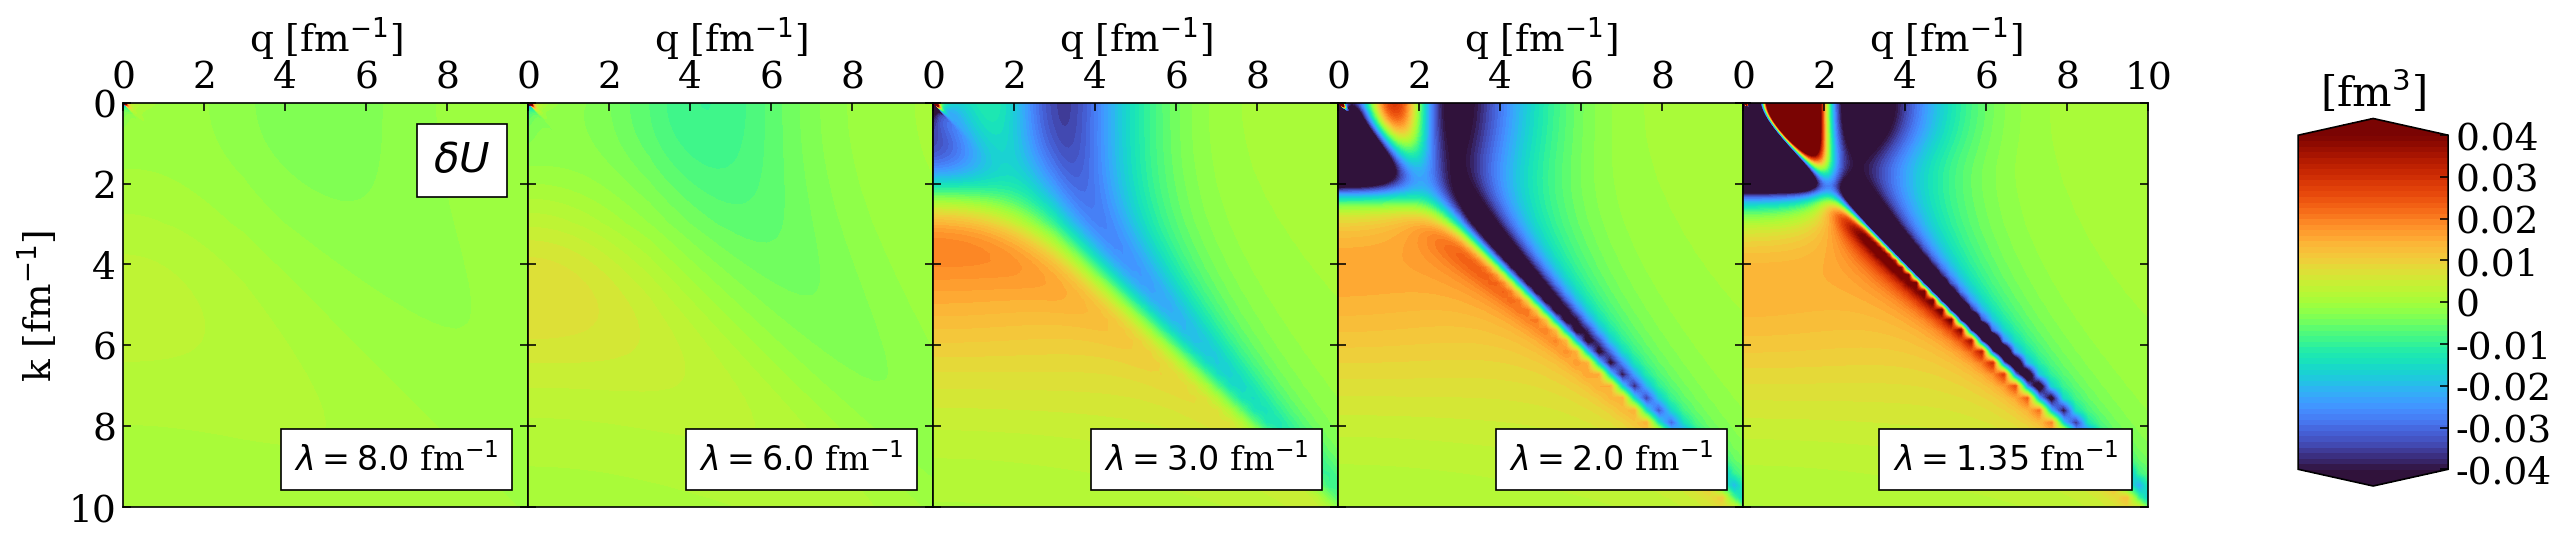

In [10]:
# Heat maps of \delta U

# Size of figure
row_number = 1
col_number = len(lambdas)
figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
# Axes limits
axes_max = 10.0
axes_lim = (0.0, axes_max)
    
# Axes ticks, labels, and fontsizes
x_label = 'q [fm' + r'$^{-1}$' + ']'
y_label = 'k [fm' + r'$^{-1}$' + ']'
axes_label_size = 18
axes_stepsize = 2.0 # Step-size in labeling tick marks
axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
axes_tick_size = 18
    
# Colorbar ticks, label, and fontsize
colorbar_limits=(-0.04, 0.04)
mn = colorbar_limits[0]
mx = colorbar_limits[1]
levels_number = 61
levels = np.linspace(mn, mx, levels_number)
levels_ticks = np.linspace(mn, mx, 9)
levels_ticks_strings = ff.convert_ticks_to_labels(levels_ticks)
colorbar_label = '[fm' +r'$^3$' + ']'
colorbar_label_size = 20
colorbar_tick_size = 18

# Color scheme for contour plots
color_style = 'turbo'

# Initialize figure
plt.close('all')
f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

for i, lamb in enumerate(lambdas):

    # Interpolate and store in dictionary
    k_array_int, delta_U_int = ff.interpolate_matrix(q_array, d[lamb][:ntot, :ntot], axes_max+0.2)
        
    c = axs[i].contourf(k_array_int, k_array_int, delta_U_int, levels, cmap=color_style, extend='both')
        
    # Specify axes limits
    axs[i].set_xlim( axes_lim )
    axs[i].set_ylim( axes_lim )
                     
    # Specify axes tick marks
    axs[i].xaxis.set_ticks(axes_ticks)
    axs[i].xaxis.set_ticklabels(axes_ticks_strings)
    # Switch from bottom to top
    axs[i].xaxis.set_label_position('top')
    axs[i].xaxis.tick_top()
    axs[i].tick_params(labeltop=True, labelsize=axes_tick_size)

    # Set x-axis label
    axs[i].set_xlabel(x_label, fontsize=axes_label_size)
    
    # Prevent overlapping x-axis tick marks
    if i < col_number - 1:
        xticks = axs[i].xaxis.get_major_ticks()
        xticks[-1].set_visible(False)
                                         
    # On the left column, set and label y-axis
    if i == 0:
                                         
        # Specify axes tick marks
        axs[i].yaxis.set_ticks(axes_ticks)
        axs[i].yaxis.set_ticklabels(axes_ticks_strings)
        axs[i].tick_params(labelsize=axes_tick_size)
        # Set y-axis label
        axs[i].set_ylabel(y_label, fontsize=axes_label_size)

# Invert y-axis
plt.gca().invert_yaxis()
                                         
# Amount of white space in-between sub-plots
f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
# Set colorbar axes
f.subplots_adjust(right=0.8) # Adjust for colorbar space
cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
# Set tick size and labels
cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
cbar.ax.tick_params(labelsize=colorbar_tick_size)
cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
# Set colorbar label
cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

# Add \lambda label to each subplot
lamb_label_size = 16
lamb_label_location = 'lower right'
for i, lamb in enumerate(lambdas):
    lamb_label = ff.lambda_label_conversion(lamb)
    anchored_text = AnchoredText(lamb_label, loc=lamb_label_location, prop=dict(size=lamb_label_size))
    axs[i].add_artist(anchored_text)
    
# Add plot label to upper right of 1st sub-plot
plot_label_size = 20
plot_label_location = 'upper right'
plot_label = r'$\delta U$'
anchored_text = AnchoredText(plot_label, loc=plot_label_location, prop=dict(size=plot_label_size))
axs[0].add_artist(anchored_text)

# Set file name
file_name = 'delU_contours_%s' % nucleus_name
# Add each channel to file name
file_name += '_channels'
for ichannel in channels:
    file_name += '_%s' % ichannel
file_name += '_kvnn_%d_lambdas' % 6
# Add each \lambda to file name
for ilamb in lambdas:
    file_name += '_%s' % ff.convert_number_to_string(ilamb)
file_name += '_kmax_%.1f' % kmax
file_name = ff.replace_periods(file_name)
file_name += '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

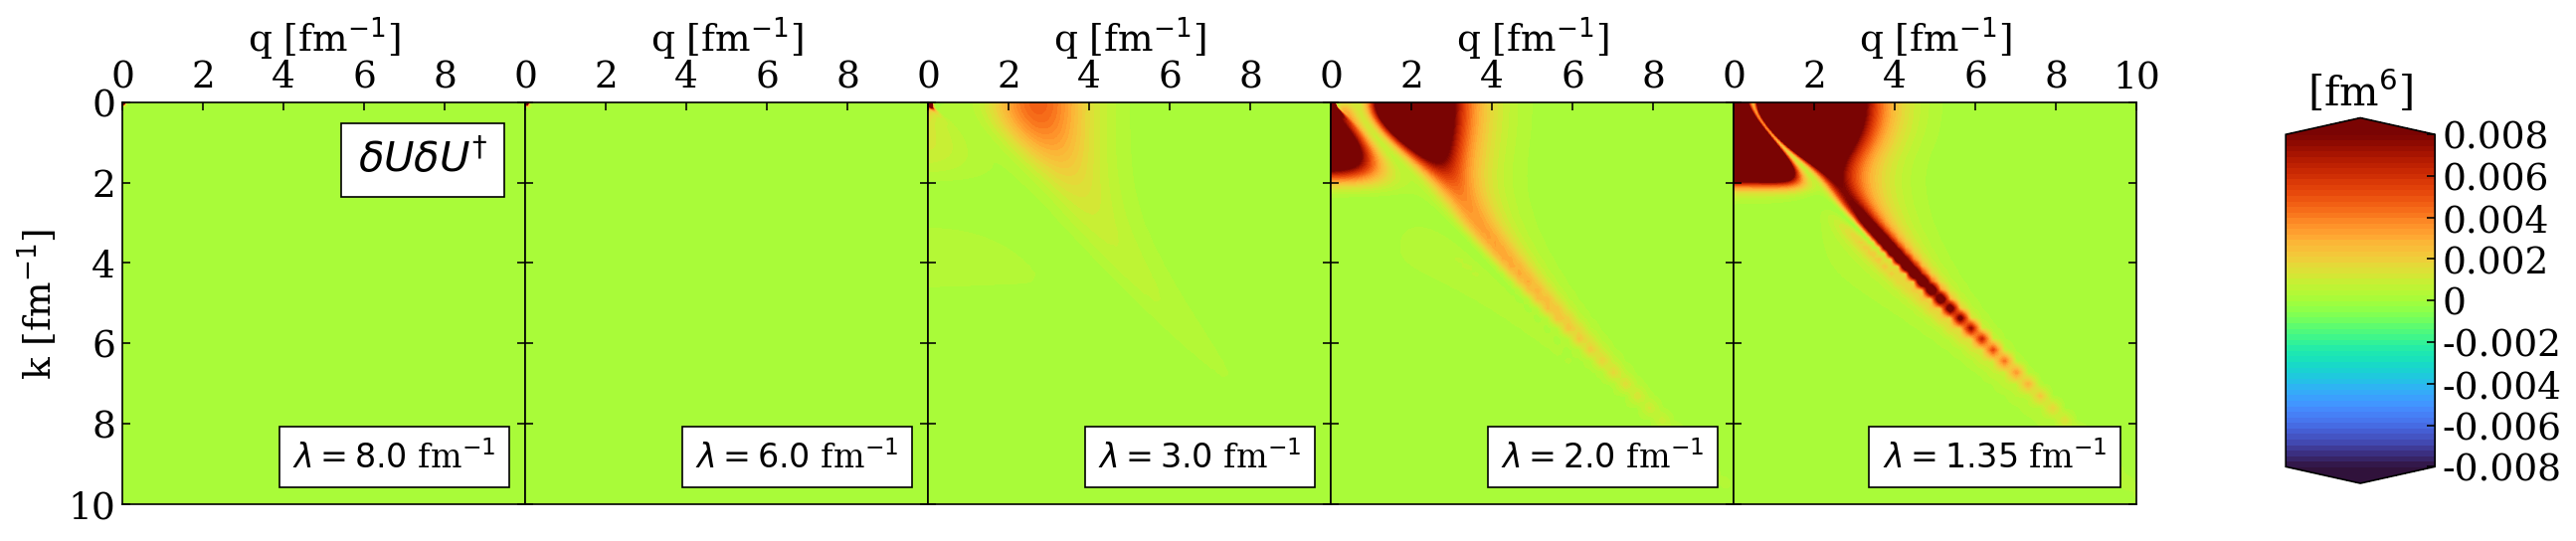

In [11]:
# Heat maps of \delta U \delta U^\dagger

# Size of figure
row_number = 1
col_number = len(lambdas)
figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
# Axes limits
axes_max = 10.0
axes_lim = (0.0, axes_max)
    
# Axes ticks, labels, and fontsizes
x_label = 'q [fm' + r'$^{-1}$' + ']'
y_label = 'k [fm' + r'$^{-1}$' + ']'
axes_label_size = 18
axes_stepsize = 2.0 # Step-size in labeling tick marks
axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
axes_tick_size = 18
    
# Colorbar ticks, label, and fontsize
colorbar_limits=(-0.008, 0.008)
mn = colorbar_limits[0]
mx = colorbar_limits[1]
levels_number = 61
levels = np.linspace(mn, mx, levels_number)
levels_ticks = np.linspace(mn, mx, 9)
levels_ticks_strings = ff.convert_ticks_to_labels(levels_ticks)
colorbar_label = '[fm' +r'$^6$' + ']'
colorbar_label_size = 20
colorbar_tick_size = 18

# Color scheme for contour plots
color_style = 'turbo'

# Initialize figure
plt.close('all')
f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

for i, lamb in enumerate(lambdas):

    # Interpolate and store in dictionary
    k_array_int, delta_U_int = ff.interpolate_matrix(q_array, d[lamb][:ntot, :ntot]**2 + d[lamb][:ntot, ntot:]**2,
                                                     axes_max+0.2)
        
    c = axs[i].contourf(k_array_int, k_array_int, delta_U_int, levels, cmap=color_style, extend='both')
        
    # Specify axes limits
    axs[i].set_xlim( axes_lim )
    axs[i].set_ylim( axes_lim )
                     
    # Specify axes tick marks
    axs[i].xaxis.set_ticks(axes_ticks)
    axs[i].xaxis.set_ticklabels(axes_ticks_strings)
    # Switch from bottom to top
    axs[i].xaxis.set_label_position('top')
    axs[i].xaxis.tick_top()
    axs[i].tick_params(labeltop=True, labelsize=axes_tick_size)

    # Set x-axis label
    axs[i].set_xlabel(x_label, fontsize=axes_label_size)
    
    # Prevent overlapping x-axis tick marks
    if i < col_number - 1:
        xticks = axs[i].xaxis.get_major_ticks()
        xticks[-1].set_visible(False)
                                         
    # On the left column, set and label y-axis
    if i == 0:
                                         
        # Specify axes tick marks
        axs[i].yaxis.set_ticks(axes_ticks)
        axs[i].yaxis.set_ticklabels(axes_ticks_strings)
        axs[i].tick_params(labelsize=axes_tick_size)
        # Set y-axis label
        axs[i].set_ylabel(y_label, fontsize=axes_label_size)

# Invert y-axis
plt.gca().invert_yaxis()
                                         
# Amount of white space in-between sub-plots
f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
# Set colorbar axes
f.subplots_adjust(right=0.8) # Adjust for colorbar space
cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
# Set tick size and labels
cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
cbar.ax.tick_params(labelsize=colorbar_tick_size)
cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
# Set colorbar label
cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

# Add \lambda label to each subplot
lamb_label_size = 16
lamb_label_location = 'lower right'
for i, lamb in enumerate(lambdas):
    lamb_label = ff.lambda_label_conversion(lamb)
    anchored_text = AnchoredText(lamb_label, loc=lamb_label_location, prop=dict(size=lamb_label_size))
    axs[i].add_artist(anchored_text)
    
# Add plot label to upper right of 1st sub-plot
plot_label_size = 20
plot_label_location = 'upper right'
plot_label = r'$\delta U \delta U^{\dagger}$'
anchored_text = AnchoredText(plot_label, loc=plot_label_location, prop=dict(size=plot_label_size))
axs[0].add_artist(anchored_text)

# Set file name
file_name = 'delU2_contours_%s' % nucleus_name
# Add each channel to file name
file_name += '_channels'
for ichannel in channels:
    file_name += '_%s' % ichannel
file_name += '_kvnn_%d_lambdas' % 6
# Add each \lambda to file name
for ilamb in lambdas:
    file_name += '_%s' % ff.convert_number_to_string(ilamb)
file_name += '_kmax_%.1f' % kmax
file_name = ff.replace_periods(file_name)
file_name += '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

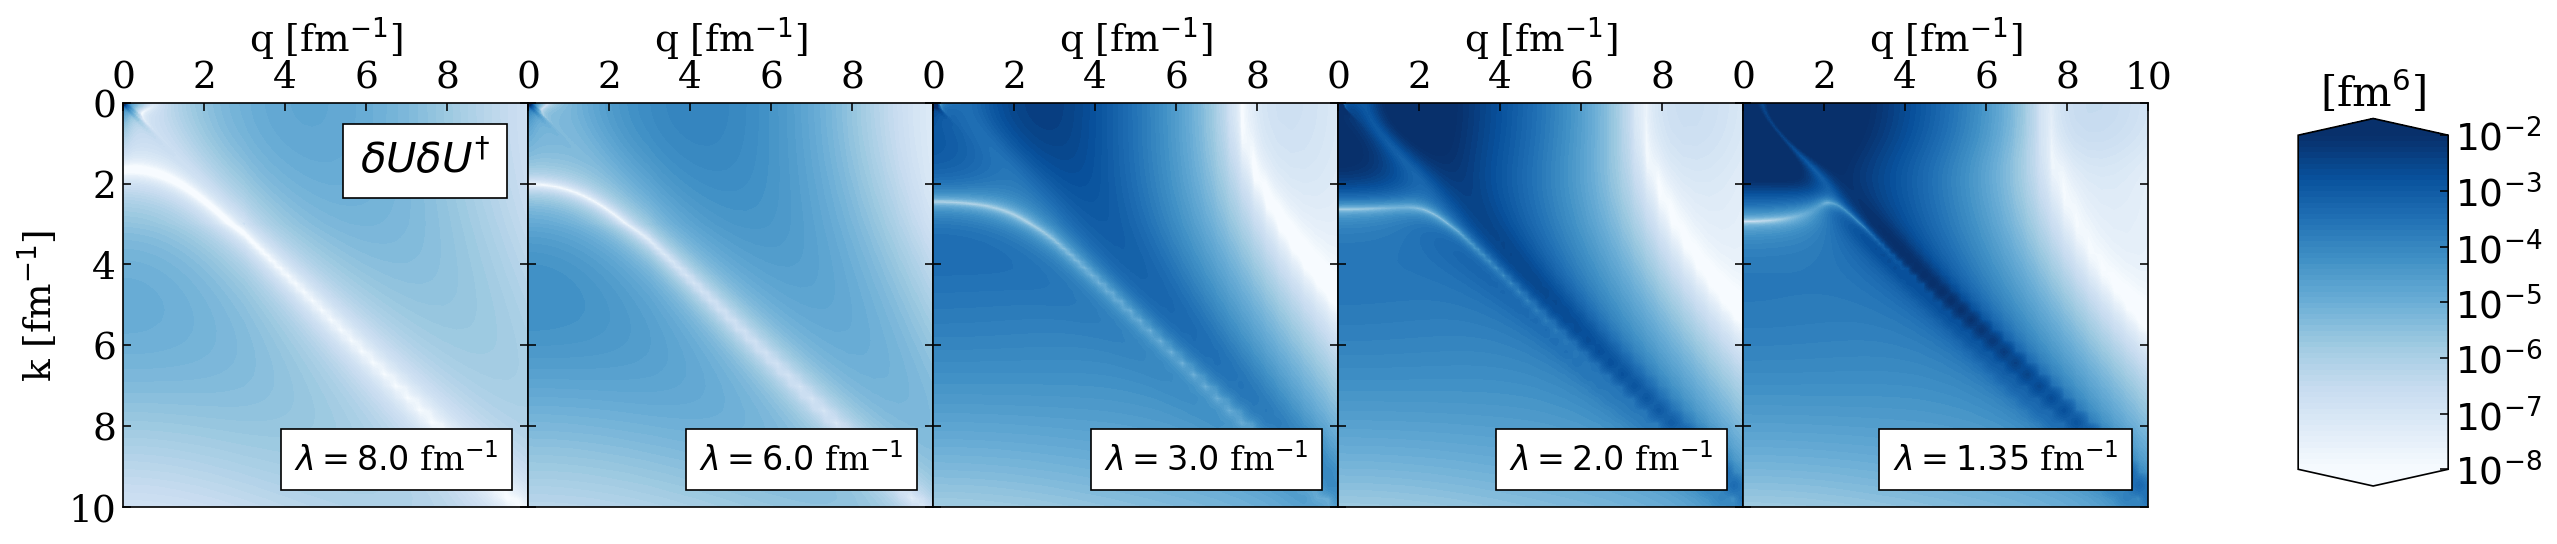

In [12]:
# Heat maps of \delta U \delta U^\dagger (log scale)

# Size of figure
row_number = 1
col_number = len(lambdas)
figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
# Axes limits
axes_max = 10.0
axes_lim = (0.0, axes_max)
    
# Axes ticks, labels, and fontsizes
x_label = 'q [fm' + r'$^{-1}$' + ']'
y_label = 'k [fm' + r'$^{-1}$' + ']'
axes_label_size = 18
axes_stepsize = 2.0 # Step-size in labeling tick marks
axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
axes_tick_size = 18
    
# Colorbar ticks, label, and fontsize
colorbar_limits=(-8, -2)
mn = colorbar_limits[0]
mx = colorbar_limits[1]
levels_number = 61
levels = np.logspace(mn, mx, levels_number)
levels_ticks = np.logspace(mn, mx, mx-mn+1)
levels_ticks_strings = [r'$10^{%d}$' % step for step in range(mn, mx+1)]
colorbar_label = '[fm' +r'$^6$' + ']'
colorbar_label_size = 20
colorbar_tick_size = 18

# Color scheme for contour plots
color_style = 'Blues'

# Initialize figure
plt.close('all')
f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

for i, lamb in enumerate(lambdas):

    # Interpolate and store in dictionary
    k_array_int, delta_U_int = ff.interpolate_matrix(q_array, d[lamb][:ntot, :ntot]**2 + d[lamb][:ntot, ntot:]**2,
                                                     axes_max+0.2)
        
    c = axs[i].contourf(k_array_int, k_array_int, delta_U_int, levels, norm=colors.LogNorm(),
                        cmap=color_style, extend='both')
        
    # Specify axes limits
    axs[i].set_xlim( axes_lim )
    axs[i].set_ylim( axes_lim )
                     
    # Specify axes tick marks
    axs[i].xaxis.set_ticks(axes_ticks)
    axs[i].xaxis.set_ticklabels(axes_ticks_strings)
    # Switch from bottom to top
    axs[i].xaxis.set_label_position('top')
    axs[i].xaxis.tick_top()
    axs[i].tick_params(labeltop=True, labelsize=axes_tick_size)

    # Set x-axis label
    axs[i].set_xlabel(x_label, fontsize=axes_label_size)
    
    # Prevent overlapping x-axis tick marks
    if i < col_number - 1:
        xticks = axs[i].xaxis.get_major_ticks()
        xticks[-1].set_visible(False)
                                         
    # On the left column, set and label y-axis
    if i == 0:
                                         
        # Specify axes tick marks
        axs[i].yaxis.set_ticks(axes_ticks)
        axs[i].yaxis.set_ticklabels(axes_ticks_strings)
        axs[i].tick_params(labelsize=axes_tick_size)
        # Set y-axis label
        axs[i].set_ylabel(y_label, fontsize=axes_label_size)

# Invert y-axis
plt.gca().invert_yaxis()
                                         
# Amount of white space in-between sub-plots
f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
# Set colorbar axes
f.subplots_adjust(right=0.8) # Adjust for colorbar space
cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
# Set tick size and labels
cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
cbar.ax.tick_params(labelsize=colorbar_tick_size)
cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
# Set colorbar label
cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

# Add \lambda label to each subplot
lamb_label_size = 16
lamb_label_location = 'lower right'
for i, lamb in enumerate(lambdas):
    lamb_label = ff.lambda_label_conversion(lamb)
    anchored_text = AnchoredText(lamb_label, loc=lamb_label_location, prop=dict(size=lamb_label_size))
    axs[i].add_artist(anchored_text)
    
# Add plot label to upper right of 1st sub-plot
plot_label_size = 20
plot_label_location = 'upper right'
plot_label = r'$\delta U \delta U^{\dagger}$'
anchored_text = AnchoredText(plot_label, loc=plot_label_location, prop=dict(size=plot_label_size))
axs[0].add_artist(anchored_text)

# Set file name
file_name = 'delU2_logscale_contours_%s' % nucleus_name
# Add each channel to file name
file_name += '_channels'
for ichannel in channels:
    file_name += '_%s' % ichannel
file_name += '_kvnn_%d_lambdas' % 6
# Add each \lambda to file name
for ilamb in lambdas:
    file_name += '_%s' % ff.convert_number_to_string(ilamb)
file_name += '_kmax_%.1f' % kmax
file_name = ff.replace_periods(file_name)
file_name += '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

1.0032857275973

q = 0.001 and \delta U^2(1, q) = 2.41625e-01
q = 0.006 and \delta U^2(1, q) = 2.41618e-01
q = 0.015 and \delta U^2(1, q) = 2.41522e-01
q = 0.028 and \delta U^2(1, q) = 2.41242e-01
q = 0.045 and \delta U^2(1, q) = 2.40620e-01
q = 0.066 and \delta U^2(1, q) = 2.39483e-01
q = 0.091 and \delta U^2(1, q) = 2.37637e-01
q = 0.120 and \delta U^2(1, q) = 2.34891e-01
q = 0.152 and \delta U^2(1, q) = 2.31055e-01
q = 0.188 and \delta U^2(1, q) = 2.25925e-01
q = 0.228 and \delta U^2(1, q) = 2.19289e-01
q = 0.271 and \delta U^2(1, q) = 2.10924e-01
q = 0.317 and \delta U^2(1, q) = 2.00620e-01
q = 0.366 and \delta U^2(1, q) = 1.88214e-01
q = 0.419 and \delta U^2(1, q) = 1.73615e-01
q = 0.474 and \delta U^2(1, q) = 1.56849e-01
q = 0.533 and \delta U^2(1, q) = 1.38093e-01
q = 0.593 and \delta U^2(1, q) = 1.17714e-01
q = 0.657 and \delta U^2(1, q) = 9.63066e-02
q = 0.722 and \delta U^2(1, q) = 7.47068e-02
q = 0.790 and \delta U^2(1, q) = 5.39678e-02
q = 0.859 and \delta U^2(1, q) = 3.52998e-02
q = 0.930 